# 实验内容

```
data
├─classification_dataset
│      15351234_Sample_KNN_classification.csv
│      15351234_Sample_NB_classification.csv
│      test_set.csv
│      train_set.csv
│      validation_set.csv
│
└─regression_dataset
        15351234_Sample_KNN_regression.csv
        15351234_Sample_NB_regression.csv
        test_set.csv
        train_set.csv
        validation_set.csv
        validation相关度评估.xlsx
```


# 分类

## 数据预处理及分析


### 数据读取函数实现

In [6]:
import pandas as pd

def loadDataSet(filePath):
    '''读取数据集函数'''
    #读取CSV文件
    df = pd.read_csv(filePath)
    #得到数据集标签
    label = list(df['label'].values)  
    #得到数据集
    dataSet = [i.strip().split(' ') for i in list(df['Words (split by space)'].values)]
    #得到数据集的所有不重复的词
    allWords = list(set([j for i in dataSet for j in i]))
    
    ############输出数据集相关信息###########################
    #输出第一行数据
    print('【one line\'s data preview】:')
    display(df.head(1))
    #输出所有label的分布
    print('【count of all kind of labels】:\n')
    print(df['label'].value_counts())
    #输出所有的词的个数
    print('【number of all words】: ', len(allWords))
    print('【number of texts】: ', len(df))
    ############输出数据集相关信息###########################
    
    return dataSet, label, allWords

### 读取训练集、验证集、测试集

In [7]:
dataPath = '.\\data\\classification_dataset\\'
trainSet, trainSet_label, allWords_trainSet = loadDataSet(dataPath+'train_set.csv')

【one line's data preview】:


,Words (split by space),label
0,europe retain trophy with big win,joy


【count of all kind of labels】:

joy         222
sad         132
surprise    113
fear         95
anger        41
disgust      20
Name: label, dtype: int64
【number of all words】:  2087
【number of texts】:  623


In [162]:
validatePath = dataPath+'validation_set.csv'
validateSet, validateSet_label, allWords_validateSet = loadDataSet(validatePath)

【one line's data preview】:


,Words (split by space),label
0,marijuana helps ease hiv nerve pain study says,surprise


【count of all kind of labels】:

joy         112
sad          65
fear         54
surprise     46
anger        21
disgust      13
Name: label, dtype: int64
【number of all words】:  1235
【number of texts】:  311


In [9]:
testSet, _ , allWords_testSet = loadDataSet(dataPath+'test_set.csv')

【one line's data preview】:


,textid,Words (split by space),label
0,1,senator carl krueger thinks ipods can kill you,?


【count of all kind of labels】:

?    312
Name: label, dtype: int64
【number of all words】:  1273
【number of texts】:  312


合并三个数据集的所有不重复的词，供后续得到onehot和TF矩阵使用。

In [10]:
allWords_train_validate = list(set(allWords_trainSet).union(allWords_validateSet))
allWords_train_test = list(set(allWords_trainSet).union(allWords_testSet))
len(allWords_train_validate), len(allWords_train_test)

(2722, 2771)

## knn分类算法

### 得到3个数据集的onehot矩阵

In [77]:
def getOneHot(dataSet, allWords):
    '''得到输入数据集的one-hot矩阵'''
    oneHot=[]
    for index, doc in enumerate(dataSet):
        oneHot.append([])
        for word in allWords:
            if word in doc:
                oneHot[index].append(1)
            else: 
                oneHot[index].append(0)
    return oneHot

#得到训练集、验证集、测试集的onehot矩阵
oneHot_trainSet = getOneHot(trainSet, allWords_train_validate)
oneHot_validateSet = getOneHot(validateSet, allWords_train_validate)

oneHot_trainSet_ = getOneHot(trainSet, allWords_train_test)
oneHot_testSet = getOneHot(testSet, allWords_train_test)

### 得到3个数据集的TF矩阵

In [78]:
from collections import Counter

def getTF(dataSet, allWords):
    '''得到输入数据集的TF矩阵'''
    TF=[]
    for index, doc in enumerate(dataSet):
        TF.append([])
        wordCounter = Counter(doc)
        for word in allWords:
            TF[index].append(wordCounter.get(word,0)/len(doc))
    return TF

#得到训练集、验证集、测试集的TF矩阵
TF_trainSet = getTF(trainSet, allWords_train_validate)
TF_validateSet = getTF(validateSet, allWords_train_validate)

TF_trainSet_ = getTF(trainSet, allWords_train_test)
TF_testSet = getTF(testSet, allWords_train_test)

### 分类函数实现及简单测试

In [28]:
import numpy as np
from collections import Counter

def knn_classify(dataSet, labels, k, inputVector):
    '''使用knn对输入的向量进行分类，使用欧式距离'''
    #得到输入向量与数据集的差值的平方
    diffMat = (np.array(dataSet) - np.array(inputVector))**2
    #计算每一行上元素的和并开方，得到距离向量
    distances = np.sqrt(diffMat.sum(axis=1))
    #得到 K个近邻的下标
    kNeighborsIndex  = distances.argpartition(k-1)[0:k]
    #返回分类结果
    return Counter(np.array(labels)[kNeighborsIndex]).most_common(1)[0][0]

knn_classify([[1,1,0,0],
              [0,1,1,1],
              [1,0,0,1]],['positive','negative','positive'], 3, [0,1,1,0])

'positive'

In [34]:
'euclidean'
'manhattan'
'cosine'

'euclidean'

'manhattan'

'cosine'

### 使用验证集调参
#### 使用onehot矩阵

In [35]:
def run_knn_classify1(k):
    '''使用验证集得到分类准确率，进行调参'''
    hitNum = 0
    for index, wordVector in enumerate(oneHot_validateSet):
        ans = knn_classify(oneHot_trainSet, trainSet_label, k, wordVector)
        if  ans == validateSet_label[index]:
            hitNum +=1
    print("k = %2d : accuracy: %.5f%%" % (k, 100*hitNum/len(validateSet)))
    
for k in range(1,50):
    run_knn_classify1(k)

k =  1 : accuracy: 37.29904%
k =  2 : accuracy: 26.04502%
k =  3 : accuracy: 37.62058%
k =  4 : accuracy: 32.47588%
k =  5 : accuracy: 32.15434%
k =  6 : accuracy: 32.47588%
k =  7 : accuracy: 36.33441%
k =  8 : accuracy: 36.01286%
k =  9 : accuracy: 37.29904%
k = 10 : accuracy: 39.87138%
k = 11 : accuracy: 39.54984%
k = 12 : accuracy: 39.22830%
k = 13 : accuracy: 40.83601%
k = 14 : accuracy: 42.44373%
k = 15 : accuracy: 39.54984%
k = 16 : accuracy: 41.15756%
k = 17 : accuracy: 40.51447%
k = 18 : accuracy: 38.58521%
k = 19 : accuracy: 38.26367%
k = 20 : accuracy: 38.90675%
k = 21 : accuracy: 38.58521%
k = 22 : accuracy: 38.26367%
k = 23 : accuracy: 37.94212%
k = 24 : accuracy: 37.94212%
k = 25 : accuracy: 37.94212%
k = 26 : accuracy: 37.62058%
k = 27 : accuracy: 36.97749%
k = 28 : accuracy: 37.29904%
k = 29 : accuracy: 37.94212%
k = 30 : accuracy: 37.29904%
k = 31 : accuracy: 36.65595%
k = 32 : accuracy: 37.29904%
k = 33 : accuracy: 37.94212%
k = 34 : accuracy: 38.58521%
k = 35 : accur

#### 使用TF矩阵

In [36]:
def run_knn_classify2(k):
    '''使用验证集得到分类准确率，进行调参'''
    hitNum = 0
    for index, wordVector in enumerate(TF_validateSet):
        ans = knn_classify(TF_trainSet, trainSet_label, k, wordVector)
        if  ans == validateSet_label[index]:
            hitNum +=1
    print("k = %2d : accuracy: %.5f%%" % (k, 100*hitNum/len(validateSet)))
    
for k in range(1,50):
    run_knn_classify2(k)

k =  1 : accuracy: 32.47588%
k =  2 : accuracy: 25.72347%
k =  3 : accuracy: 24.75884%
k =  4 : accuracy: 25.08039%
k =  5 : accuracy: 23.47267%
k =  6 : accuracy: 25.40193%
k =  7 : accuracy: 26.36656%
k =  8 : accuracy: 27.97428%
k =  9 : accuracy: 27.97428%
k = 10 : accuracy: 25.72347%
k = 11 : accuracy: 26.36656%
k = 12 : accuracy: 26.68810%
k = 13 : accuracy: 29.26045%
k = 14 : accuracy: 29.58199%
k = 15 : accuracy: 30.54662%
k = 16 : accuracy: 30.86817%
k = 17 : accuracy: 28.29582%
k = 18 : accuracy: 28.29582%
k = 19 : accuracy: 26.36656%
k = 20 : accuracy: 27.97428%
k = 21 : accuracy: 27.33119%
k = 22 : accuracy: 28.29582%
k = 23 : accuracy: 28.29582%
k = 24 : accuracy: 27.97428%
k = 25 : accuracy: 27.97428%
k = 26 : accuracy: 28.61736%
k = 27 : accuracy: 29.26045%
k = 28 : accuracy: 27.65273%
k = 29 : accuracy: 28.29582%
k = 30 : accuracy: 28.29582%
k = 31 : accuracy: 27.65273%
k = 32 : accuracy: 27.00965%
k = 33 : accuracy: 27.00965%
k = 34 : accuracy: 27.00965%
k = 35 : accur

### 对测试集进行分类
#### 使用onehot矩阵

In [43]:
outputFileName = "15352220_linzecheng_KNN_classification_onehot.csv"
bestK = 14
textid_and_label = []
for index, wordVector in enumerate(oneHot_testSet):
        ans = knn_classify(oneHot_trainSet_, trainSet_label, bestK, wordVector)
        textid_and_label.append((index+1, ans))
        
res = pd.DataFrame(textid_and_label, columns=['textid','label'])
res.to_csv(outputFileName, index=False)

In [45]:
res['label'].value_counts()

joy         218
fear         57
sad          35
surprise      2
Name: label, dtype: int64

#### 使用TF矩阵

In [46]:
outputFileName = "15352220_linzecheng_KNN_classification_TF.csv"
bestK = 16
textid_and_label = []
for index, wordVector in enumerate(TF_testSet):
        ans = knn_classify(TF_trainSet_, trainSet_label, bestK, wordVector)
        textid_and_label.append((index+1, ans))
        
res2 = pd.DataFrame(textid_and_label, columns=['textid','label'])
res2.to_csv(outputFileName, index=False)

In [47]:
res2['label'].value_counts()

surprise    186
joy          49
sad          32
fear         23
anger        22
Name: label, dtype: int64

## NB分类算法

### 得到3个数据集的频次矩阵

该矩阵用于NB的分类问题。

In [154]:
import numpy as np

def getFreq(trainSet, trainSet_label, allWordsNum_train,
            allWords_train_other, lambda_):
    '''得到输入训练集的频次矩阵、所有可能的标签、对应的标签的概率'''
    def calcProbs(numerator, denominator):
        '''根据输入的分子和分母计算先验概率值'''
        return (numerator+lambda_) / (denominator+lambda_*allWordsNum_train)
    #先将数据类型转为numpy.array
    trainSet = np.array(trainSet)
    trainSet_label = np.array(trainSet_label)
    
    #得到所有可能的标签
    allLabels = list(set(trainSet_label))
    freqMat = dict() #要返回的频次矩阵
    labelPros = dict() #要返回的标签的概率
    #遍历所有标签
    for label in allLabels:
        #找到所有标签为 label 的 documents
        allDocs_with_label = trainSet[np.argwhere(trainSet_label==label)[:,0]]
        #计算每个 label 出现的概率
        labelPros[label] = len(allDocs_with_label)/len(trainSet)
        #得到上面的所有 documents 中的所有词
        allWords_with_label = [j for i in list(allDocs_with_label) for j in i]
        #词频统计
        wordCounter = Counter(allWords_with_label)
        #预分配内存
        freqMat[label] = [0]*len(allWords_train_other)
        #求先验概率时的分母
        denominator_ = len(allWords_with_label)
        #遍历所有词，计算在标签为label的前提下词出现的概率
        for index, word in enumerate(allWords_train_other):
            freqMat[label][index] = calcProbs(wordCounter.get(word,0), denominator_)
            
    return freqMat, allLabels, labelPros

####################测试程序#################
a = [['a','b'], ['b','c']]              #trainSet
b = len(set([j for i in a for j in i])) #allWordsNum_train
c = [['e','a'], ['c','f']]              #otherSet
                                        #allWords_train_other
d = list(set([j for i in a for j in i]).union([j for i in c for j in i]))
e = ['good', 'bad']                     #trainSet_label
a, b, c
d, e
getFreq(a, e, b, d, lambda_=1)          #使用拉普拉斯平滑
####################测试程序#################

([['a', 'b'], ['b', 'c']], 3, [['e', 'a'], ['c', 'f']])

(['e', 'b', 'f', 'c', 'a'], ['good', 'bad'])

({'bad': [0.2, 0.4, 0.2, 0.4, 0.2], 'good': [0.2, 0.4, 0.2, 0.2, 0.4]},
 ['good', 'bad'],
 {'bad': 0.5, 'good': 0.5})

这里给出了一个例子测试该函数的正确性：

给定的训练集`a=[['a', 'b'], ['b', 'c']]`, 对应的lable为`e=['good', 'bad']`, b为a中的所有不重复词的长度3。

给定测试集（或验证集）`c=[['e','a'], ['c','f']]`, 可得两个数据集中所有不重复的词的向量为：

`d=['e', 'b', 'f', 'c', 'a']`

因此，选择拉普拉斯平滑的多项式模型计算，对应的频次矩阵为：

```
{'bad': [(0+1)/(2+3), (1+1)/(2+3), (0+1)/(2+3), (1+1)/(2+3), (0+1)/(2+3)],

'good': [ [(0+1)/(2+3), (1+1)/(2+3), (0+1)/(2+3), (0+1)/(2+3), (1+1)/(2+3)]}
```

即为：
```
         'e'  'b'  'f'  'c'  'a'
{'bad': [0.2, 0.4, 0.2, 0.4, 0.2],
'good': [0.2, 0.4, 0.2, 0.2, 0.4]}
```

而根据训练集得到的每个label的概率P(label)为:`P(good)=1/2=0.5=P(bad)`

可见，输出结果正确，该函数功能正常。

对于需要预测分类的数据集：`c=[['e','a'], ['c','f']]`, 有：

```
P('good'|['e','a']) = P('e'|'good') * P('a'|'good') * P('good')
                    = 0.2 * 0.4 * 0.5 = 0.04
                    
P('bad'|['e','a']) = P('e'|'bad') * P('a'|'bad') * P('bad')
                    = 0.2 * 0.2 * 0.5 = 0.02

P('good'|['c','f']) = P('c'|'good') * P('f'|'good') * P('good')
                    = 0.2 * 0.2 * 0.5 = 0.02
                    
P('bad'|['c','f'] = P('c'|'bad') * P('f'|'bad') * P('bad')
                    = 0.4 * 0.2 * 0.5 = 0.04 
```

因此，`['e','a']`的分类为`'good'`；而`['c','f']`的分类为`'bad'`。

### 分类函数实现及简单测试

In [160]:
from functools import reduce

def NB_classify(trainSet, trainSet_label, allWordsNum_train, allWords_train_other,
                otherSet, lambda_):
    #得到频次矩阵、所有可能的标签、标签概率
    freqMat_, allLabels_, labelPros_ = getFreq(trainSet, trainSet_label, 
                    allWordsNum_train,allWords_train_other, lambda_=lambda_)
    ans = [] #存储每行数据对应的最终预测分类
    allWords_ = np.array(allWords_train_other)
    ####print("所有词：", allWords_)
    for data in otherSet:
        #得到当前的一行数据中词在所有词向量allWords_的下标
        matchIndex = np.array([np.argwhere(allWords_ == word)[0][0] 
                                                    for word in data])
        temp = []
        ####print("当前测试文本：", data)
        ####print("在所有词中下标：", matchIndex)
        for label in allLabels_:
            #得到对应label的所有词的概率列表
            probs = np.array(freqMat_[label])
            #得到基于label的概率值
            p = reduce(lambda x,y:x*y, probs[matchIndex]) * labelPros_[label]
            #保存概率结果和对应的label值
            temp.append((p, label))
        #得到概率值最大时对应的label值
        ####print("分为不同类的概率：\n", temp)
        ans.append(max(temp)[1])
    #返回结果
    return ans

NB_classify(a, e, b, d, c, lambda_=1) #使用拉普拉斯平滑

['good', 'bad']

In [157]:
####################测试程序#################
NB_classify(a, e, b, d, c, lambda_=1) #使用拉普拉斯平滑
####################测试程序#################

所有词： ['e' 'b' 'f' 'c' 'a']
当前测试文本： ['e', 'a']
在所有词中下标： [0 4]
分为不同类的概率：
 [(0.040000000000000008, 'good'), (0.020000000000000004, 'bad')]
当前测试文本： ['c', 'f']
在所有词中下标： [3 2]
分为不同类的概率：
 [(0.020000000000000004, 'good'), (0.040000000000000008, 'bad')]


['good', 'bad']

这里输出表明`['e','a']`的分类为`'good'`；而`['c','f']`的分类为`'bad'`，与预期想符合。

### 使用验证集调参

这里需要调参的地方就是：平滑系数 $\lambda$ 的选择了。

In [212]:
def run_NB_classify(lambda_):
    '''使用验证集得到分类准确率，进行调参''' 
    #调用 NB 分类函数
    predictLabel = NB_classify(trainSet, trainSet_label, len(allWords_trainSet),
                               allWords_train_validate, validateSet, lambda_)
    predictLabel = np.array(predictLabel)
    validateSet_label_ = np.array(validateSet_label)
    hitRate = len(predictLabel[predictLabel==validateSet_label_])/len(validateSet)
    #print("lambda = %.5f : accuracy: %.5f%%" % (lambda_, 100*hitRate))
    return hitRate
    
maxHitRate, bestLambda = 0, 0

testRange =  np.arange(0,3.1,0.05)
hitRates = np.zeros((1, len(testRange))).flatten()

for index, lambda_ in enumerate(testRange):
    hitRate = run_NB_classify(lambda_) * 100
    hitRates[index] = hitRate
    if hitRate > maxHitRate:
        maxHitRate = hitRate
        bestLambda = lambda_

print('max accuracy is %.5f%% when lambda is %.5f' % (maxHitRate, bestLambda))

max accuracy is 45.65916% when lambda is 1.20000


可见，在 $\lambda$ 为1.2时，分类率最高，为45.65916%。 下面来绘制随着 $\lambda$ 改变，NB分类准确率的变化图：

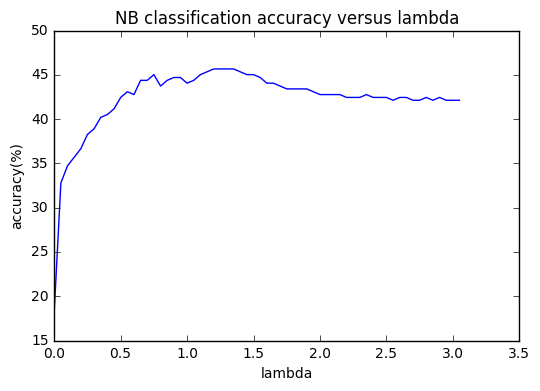

In [270]:
import matplotlib.pyplot as plt

_ = plt.plot(testRange, hitRates)
_ = plt.xlabel('lambda')
_ = plt.ylabel('accuracy(%)')
_ = plt.title("NB classification accuracy versus lambda")
plt.show()
plt.close()

### 对测试集进行分类

In [218]:
outputFileName = "15352220_linzecheng_NB_classification.csv"

#调用 NB 分类函数
predictLabel = NB_classify(trainSet, trainSet_label, len(allWords_trainSet),
                           allWords_train_test, testSet, bestLambda)
        
textid_and_label = [(i, j) for i in np.arange(1,len(testSet)+1) for j in predictLabel]
res = pd.DataFrame(textid_and_label, columns=['textid','label'])
res.to_csv(outputFileName, index=False)

# 回归

## 数据预处理及分析

### 数据读取函数实现

In [223]:
import pandas as pd

def loadDataSet2(filePath):
    '''读取数据集函数'''
    #读取CSV文件
    df = pd.read_csv(filePath)
    #得到数据集标签
    label = dict()
    label['anger'] = list(df['anger'].values)  
    label['disgust'] = list(df['disgust'].values)  
    label['fear'] = list(df['fear'].values)
    label['joy'] = list(df['joy'].values)  
    label['sad'] = list(df['sad'].values)  
    label['surprise'] = list(df['surprise'].values)  
    #得到数据集
    dataSet = [i.strip().split(' ') for i in list(df['Words (split by space)'].values)]
    #得到数据集的所有不重复的词
    allWords = list(set([j for i in dataSet for j in i]))
    
    ############输出数据集相关信息###########################
    #输出第一行数据
    print('【one line\'s data preview】:')
    display(df.head(1))
    #输出所有情感值的一些统计数据
    print('【some summary statistics of labels】:')
    print(df[['anger','disgust','fear','joy','sad','surprise']].describe())
    #输出所有的词的个数
    print('【number of all words】: ', len(allWords))
    print('【number of texts】: ', len(df))
    ############输出数据集相关信息###########################
    
    return dataSet, label, allWords

### 读取训练集、验证集、测试集

In [224]:
dataPath2 = '.\\data\\regression_dataset\\'
trainPath = dataPath2+'train_set.csv'
trainSet2, trainSet_label2, allWords_trainSet2 = loadDataSet2(trainPath)

【one line's data preview】:


,Words (split by space),anger,disgust,fear,joy,sad,surprise
0,europe retain trophy with big win,0.0,0.0,0.0,0.8721,0.0,0.1279


【some summary statistics of labels】:
            anger     disgust        fear         joy         sad    surprise
count  623.000000  623.000000  623.000000  623.000000  623.000000  623.000000
mean     0.086573    0.052949    0.157176    0.281344    0.191442    0.230517
std      0.123334    0.090709    0.174959    0.317420    0.206464    0.199993
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.090100
50%      0.022700    0.000000    0.115400    0.130800    0.142900    0.176500
75%      0.144950    0.083300    0.255450    0.566950    0.293450    0.326750
max      0.753400    0.571400    0.895800    1.000000    1.000000    1.000000
【number of all words】:  2087
【number of texts】:  623


In [227]:
validatePath = dataPath2+'validation_set.csv'
validateSet2, validateSet_label2, allWords_validateSet2 = loadDataSet2(validatePath)

【one line's data preview】:


,Words (split by space),anger,disgust,fear,joy,sad,surprise
0,marijuana helps ease hiv nerve pain study says,0.0,0.0,0.0744,0.2727,0.0992,0.5537


【some summary statistics of labels】:
            anger     disgust        fear         joy         sad    surprise
count  311.000000  311.000000  311.000000  311.000000  311.000000  311.000000
mean     0.085478    0.062534    0.151173    0.287755    0.194680    0.218382
std      0.125672    0.110057    0.175016    0.310162    0.208836    0.189515
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.073650
50%      0.012200    0.000000    0.088900    0.177800    0.138900    0.181800
75%      0.150600    0.098400    0.245550    0.553650    0.300900    0.320900
max      0.777800    0.785700    0.815400    1.000000    0.903200    1.000000
【number of all words】:  1235
【number of texts】:  311


In [228]:
testSet2, _ , allWords_testSet2 = loadDataSet2(dataPath2+'test_set.csv')

【one line's data preview】:


,textid,Words (split by space),anger,disgust,fear,joy,sad,surprise
0,1,senator carl krueger thinks ipods can kill you,?,?,?,?,?,?


【some summary statistics of labels】:
       anger disgust fear  joy  sad surprise
count    312     312  312  312  312      312
unique     1       1    1    1    1        1
top        ?       ?    ?    ?    ?        ?
freq     312     312  312  312  312      312
【number of all words】:  1273
【number of texts】:  312


In [229]:
allWords_train_validate2 = list(set(allWords_trainSet2).union(allWords_validateSet2))
allWords_train_test2 = list(set(allWords_trainSet2).union(allWords_testSet2))
len(allWords_train_validate2), len(allWords_train_test2)

(2722, 2771)

## knn回归算法


###  得到3个数据集的onehot矩阵

In [55]:
#得到训练集、验证集、测试集的onehot矩阵
oneHot_trainSet2 = getOneHot(trainSet2, allWords_train_validate2)
oneHot_validateSet2 = getOneHot(validateSet2, allWords_train_validate2)

oneHot_trainSet2_ = getOneHot(trainSet2, allWords_train_test2)
oneHot_testSet2 = getOneHot(testSet2, allWords_train_test2)

### 得到3个数据集的TF矩阵

In [56]:
from collections import Counter

def getTF(dataSet, allWords):
    '''得到输入数据集的TF矩阵'''
    TF=[]
    for index, doc in enumerate(dataSet):
        TF.append([])
        wordCounter = Counter(doc)
        for word in allWords:
            TF[index].append(wordCounter.get(word,0)/len(doc))
    return TF

#得到训练集、验证集、测试集的TF矩阵
TF_trainSet2 = getTF(trainSet2, allWords_train_validate2)
TF_validateSet2 = getTF(validateSet2, allWords_train_validate2)

TF_trainSet2_ = getTF(trainSet2, allWords_train_test2)
TF_testSet2 = getTF(testSet2, allWords_train_test2)

### 权值归一化函数实现

不同意PPT里的权值归一化的说法，下面这个函数暂时不会使用。

In [230]:
def weightNormalize(weight, method='min-max'):
    '''权值归一化函数，输入权值类型为numpy.array'''
    if len(weight) == 1:
        return weight
    elif method == 'min-max':
        return (weight-weight.min())/(weight.max()-weight.min())
    elif method == 'z-score':
        return (weight-weight.mean())/weight.std()

weightNormalize(np.array([1,2,3]))
weightNormalize(np.array([1,2,3]),'z-score')

weightNormalize(np.array([5]))

array([ 0. ,  0.5,  1. ])

array([-1.22474487,  0.        ,  1.22474487])

array([5])

### 回归函数实现及简单测试

In [238]:
import numpy as np
from collections import Counter

def knn_regress(dataSet, labels, k, inputVector):
    '''使用knn对输入的向量进行回归，先默认使用欧式距离'''
    #得到输入向量与数据集的差值的平方
    diffMat = (np.array(dataSet) - np.array(inputVector))**2
    #计算每一行上元素的和并开方，得到距离向量
    distances = np.sqrt(diffMat.sum(axis=1))
    
    #要输出的label
    outputLabel = dict() 
    #label中每个分量的概率值
    probs = np.zeros((1,len(labels.keys())))
    #若距离中存在0，则直接拷贝距离为0对应元素的label
    if 0 in distances:
        zeroIndex = distances.tolist().index(0)
        for index, i in enumerate(labels.keys()):
            outputLabel[i] = labels[i][zeroIndex]
            probs[0,index] = outputLabel[i]
    else:
        #得到 K个近邻的下标
        kNeighborsIndex  = distances.argpartition(k-1)[0:k]
        #用label值除以距离并求和，更新输出的 label
        weight = 1/distances[kNeighborsIndex]
        
        for index, i in enumerate(labels.keys()):
            #得到 K个近邻的标签
            topKLabel = np.array(labels[i])[kNeighborsIndex]
            outputLabel[i] = (topKLabel*weight).sum()
            #保存当前概率值，用于后续归一化
            probs[0,index] = outputLabel[i]
    
    #将所有概率值的和调整为1
    for i in outputLabel.keys():
        outputLabel[i] = outputLabel[i] / probs.sum()
    return outputLabel

knn_regress([[1,1,0,0],[0,1,1,1],[1,0,0,1]],
            {'happy':[0.4,0.5,0.1], 
             'sad':[0.2,0.3,0.2], 
             'calm':[0.1,0.25,0.8]}, 2, [0,1,1,0])

{'calm': 0.20758311990313899,
 'happy': 0.50670259438257537,
 'sad': 0.28571428571428575}

### 使用验证集调参
#### 使用onehot矩阵

In [59]:
def run_knn_regress1(k):
    '''使用验证集得到分类准确率，进行调参'''
    ansLabel = dict()
    for i in validateSet_label2.keys():
        ansLabel[i]=[]
    for index, wordVector in enumerate(oneHot_validateSet2):
        ans = knn_regress(oneHot_trainSet2, trainSet_label2, k, wordVector)
        ######### nan 值的debug代码#########################
#         flag = False
#         for i in validateSet_label2.keys():
#             if  np.isnan(ans[i]):
#                 print('nan value found in %d' % (index))
#                 print('terminate..')
#                 flag = True
#         if flag: break
        ########## nan 值的debug代码#########################
        for i in ans.keys():
            ansLabel[i].append(ans[i])
    
    print('k =%2d：' % k)
    tot = 0
    for i in ansLabel.keys():
        corr = np.corrcoef(ansLabel[i],validateSet_label2[i])[0,1]
        tot += corr
        print('%s:%.5f' % (i, corr), end=' ')
    print('\naverage:%.5f' % (tot/len(ansLabel.keys())))
    
for k in range(1,50):
    run_knn_regress1(k)

k = 1：
disgust:0.06974 fear:0.20246 anger:0.17641 surprise:0.26274 sad:0.23562 joy:0.22842 
average:0.19590
k = 2：
disgust:0.14951 fear:0.18935 anger:0.21867 surprise:0.26140 sad:0.25384 joy:0.21249 
average:0.21421
k = 3：
disgust:0.17165 fear:0.30999 anger:0.26360 surprise:0.30961 sad:0.27188 joy:0.36031 
average:0.28117
k = 4：
disgust:0.12803 fear:0.25003 anger:0.23949 surprise:0.29278 sad:0.30006 joy:0.26669 
average:0.24618
k = 5：
disgust:0.18701 fear:0.27019 anger:0.21457 surprise:0.26512 sad:0.28487 joy:0.27987 
average:0.25027
k = 6：
disgust:0.15457 fear:0.25380 anger:0.20465 surprise:0.26812 sad:0.29012 joy:0.25840 
average:0.23828
k = 7：
disgust:0.12378 fear:0.23897 anger:0.20549 surprise:0.25716 sad:0.28532 joy:0.24048 
average:0.22520
k = 8：
disgust:0.13491 fear:0.27800 anger:0.18004 surprise:0.25414 sad:0.30558 joy:0.27249 
average:0.23753
k = 9：
disgust:0.10519 fear:0.28046 anger:0.18512 surprise:0.26503 sad:0.32458 joy:0.27891 
average:0.23988
k =10：
disgust:0.14604 fear:

#### 使用TF矩阵

In [60]:
def run_knn_regress2(k):
    '''使用验证集得到分类准确率，进行调参'''
    ansLabel = dict()
    for i in validateSet_label2.keys():
        ansLabel[i]=[]
    for index, wordVector in enumerate(TF_validateSet2):
        ans = knn_regress(TF_trainSet2, trainSet_label2, k, wordVector)
        ######### nan 值的debug代码#########################
#         flag = False
#         for i in validateSet_label2.keys():
#             if  np.isnan(ans[i]):
#                 print('nan value found in %d' % (index))
#                 print('terminate..')
#                 flag = True
#         if flag: break
        ########## nan 值的debug代码#########################
        for i in ans.keys():
            ansLabel[i].append(ans[i])
    
    print('k =%2d：' % k)
    tot = 0
    for i in ansLabel.keys():
        corr = np.corrcoef(ansLabel[i],validateSet_label2[i])[0,1]
        tot += corr
        print('%s:%.5f' % (i, corr), end=' ')
    print('\naverage:%.5f' % (tot/len(ansLabel.keys())))
    
for k in range(1,50):
    run_knn_regress2(k)

k = 1：
disgust:0.18534 fear:0.18922 anger:0.19106 surprise:0.25044 sad:0.33920 joy:0.29835 
average:0.24227
k = 2：
disgust:0.15857 fear:0.24805 anger:0.20038 surprise:0.28051 sad:0.35063 joy:0.32682 
average:0.26083
k = 3：
disgust:0.15783 fear:0.23621 anger:0.26758 surprise:0.33853 sad:0.36212 joy:0.32767 
average:0.28165
k = 4：
disgust:0.16518 fear:0.28809 anger:0.27425 surprise:0.32473 sad:0.35045 joy:0.32369 
average:0.28773
k = 5：
disgust:0.17754 fear:0.26132 anger:0.28459 surprise:0.34263 sad:0.33851 joy:0.32733 
average:0.28865
k = 6：
disgust:0.19088 fear:0.27623 anger:0.24732 surprise:0.33194 sad:0.34177 joy:0.33144 
average:0.28660
k = 7：
disgust:0.20926 fear:0.28102 anger:0.24311 surprise:0.33335 sad:0.34708 joy:0.31564 
average:0.28824
k = 8：
disgust:0.19627 fear:0.27130 anger:0.23438 surprise:0.32511 sad:0.35790 joy:0.32447 
average:0.28490
k = 9：
disgust:0.21269 fear:0.27335 anger:0.24752 surprise:0.32384 sad:0.35081 joy:0.32749 
average:0.28928
k =10：
disgust:0.19288 fear:

## NB回归算法

### 得到三个数据集的类TF矩阵

In [237]:
import numpy as np
from collections import Counter

def getSimilarTF(trainSet_, allWordsNum_train, allWords_train_other, lambda_):
    '''得到输入训练集的类TF矩阵、所有可能的标签'''
    def calcProbs(numerator, denominator):
        '''根据输入的分子和分母计算先验概率值'''
        return (numerator+lambda_) / (denominator+lambda_*allWordsNum_train)
    #预分配内存
    similarTF = np.zeros((len(trainSet_), len(allWords_train_other)))
    #遍历整个数据集
    for rowIdx, doc in enumerate(trainSet_):
        #得到所有词的词频统计
        wordCounter = Counter(doc)
        #遍历每个词
        for colIdx, word in enumerate(allWords_train_other):
            #得到矩阵每个元素的概率值
            similarTF[rowIdx, colIdx] = calcProbs(wordCounter.get(word,0), len(doc))
    
    return similarTF

####################测试程序#################
a = [['a','b'], ['b','c']]              #trainSet_
b = len(set([j for i in a for j in i])) #allWordsNum_train
c = [['e','a'], ['c','f']]              #otherSet
                                        #allWords_train_other
d = list(set([j for i in a for j in i]).union([j for i in c for j in i]))
e = {'good':[0.8, 0.2],'bad':[0.2, 0.8]}#trainSet_label
a, b, c
d, e
getSimilarTF(a, b, d, lambda_=0)        #lambda 为 0时
getSimilarTF(a, b, d, lambda_=1)        #lambda 为 1时
####################测试程序#################

([['a', 'b'], ['b', 'c']], 3, [['e', 'a'], ['c', 'f']])

(['e', 'b', 'f', 'c', 'a'], {'bad': [0.2, 0.8], 'good': [0.8, 0.2]})

array([[ 0. ,  0.5,  0. ,  0. ,  0.5],
       [ 0. ,  0.5,  0. ,  0.5,  0. ]])

array([[ 0.2,  0.4,  0.2,  0.2,  0.4],
       [ 0.2,  0.4,  0.2,  0.4,  0.2]])

下面来根据上面例子的输出来说明该函数的实现正确性。

当 $\lambda=0$ 时， 所求的即是TF矩阵，因此输出结果应为：

```
           'e'  'b'  'f'  'c'  'a'             'e'  'b'  'f'  'c'  'a'
第一行数据  0/2  1/2  0/2  0/2  1/2  ---化简-->  0   0.5   0    0    1
第二行数据  0/2  1/2  0/2  1/2  0/2              0   0.5   0   0.5   0
```
和结果相符。

当 $\lambda=1$ 时， 所求的即是使用拉普拉斯平滑的类TF矩阵，因此输出结果应为：

```
               'e'           'b'          'f'          'c'        'a'         
第一行数据  (0+1)/(2+3)  (1+1)/(2+3)  (0+1)/(2+3)  (0+1)/(2+3)  (1+1)/(2+3)
第二行数据  (0+1)/(2+3)  (1+1)/(2+3)  (0+1)/(2+3)  (1+1)/(2+3)  (0+1)/(2+3)    

---化简-->

               'e'           'b'          'f'          'c'        'a'         
第一行数据      0.2           0.4          0.2          0.2        0.4
第二行数据      0.2           0.4          0.2          0.4        0.2 
```

和结果相符。因此该函数的实现是正确的。

### 回归函数实现及简单测试

In [319]:
import numpy as np
from functools import reduce

def NB_regress(trainSet_, trainSet_label_, allWordsNum_train, allWords_train_other,
               otherSet, lambda_):
    '''使用NB进行回归，返回每个数据对应的类标签概率'''
    #得到类TF矩阵
    similarTF = getSimilarTF(trainSet_, allWordsNum_train, allWords_train_other,
                            lambda_)
    #要输出的label
    outputLabel = dict() 
    #得到所有可能的标签
    allLabels = list(trainSet_label_.keys())
    #预分配内存
    for label in allLabels:
        outputLabel[label] = np.zeros(len(otherSet))
    
    similarTF = np.array(similarTF)
    allWords_ = np.array(allWords_train_other)
    for index, data in enumerate(otherSet):
        #得到当前的一行数据中词在所有词向量allWords_的下标
        matchIndex = np.array([np.argwhere(allWords_ == word)[0][0] 
                                                    for word in data])
        #得到 P(data|d_i, class)的列向量
        probs = similarTF[:, matchIndex].prod(axis=1)
        #得到基于每个类的概率值
        temp = np.zeros(len(allLabels))
        for i, label in enumerate(allLabels):
            #对应元素相乘再相加
            temp[i] = (probs * np.array(trainSet_label_[label])).sum()
        
        #进行归一化
        for i, label in enumerate(allLabels):
            if temp.sum() != 0:
                outputLabel[label][index] = temp[i] / temp.sum()
    
    return outputLabel

####################测试程序#################
a = [['a','b'], ['b','c']]              #trainSet_
b = len(set([j for i in a for j in i])) #allWordsNum_train
c = [['e','a'], ['c','f']]              #otherSet
                                        #allWords_train_other
d = list(set([j for i in a for j in i]).union([j for i in c for j in i]))
e = {'good':[0.8, 0.2],'bad':[0.2, 0.8]}#trainSet_label
a, b, c
d, e
NB_regress(a, e, b, d, c, lambda_ = 0)  #lambda 为 0时
NB_regress(a, e, b, d, c, lambda_ = 1)  #lambda 为 1时
####################测试程序#################

([['a', 'b'], ['b', 'c']], 3, [['e', 'a'], ['c', 'f']])

(['e', 'b', 'f', 'c', 'a'], {'bad': [0.2, 0.8], 'good': [0.8, 0.2]})

{'bad': array([ 0.,  0.]), 'good': array([ 0.,  0.])}

{'bad': array([ 0.4,  0.6]), 'good': array([ 0.6,  0.4])}

下面来根据上面的输出来说明该函数的实现正确性。

首先，根据该数据集得到的类TF矩阵和对应的标签为为：

```
               'e'    'b'   'f'   'c'   'a'   | 'bad' 'good'     
第一行数据 d1   0.2    0.4   0.2   0.2   0.4   |  0.2   0.8
第二行数据 d2   0.2    0.4   0.2   0.4   0.2   |  0.8   0.2
```

则：

```
P('good'|['e', 'a']) = P('e'|d1,'good')*P('a'|d1,'good')*P(d1,'good') +
                       P('e'|d2,'good')*P('a'|d2,'good')*P(d2,'good')
                     = 0.2*0.4*0.8 + 0.2*0.2*0.2 = 0.072
                     
P('bad'|['e', 'a'])  = P('e'|d1,'bad')*P('a'|d1,'bad')*P(d1,'bad') +
                       P('e'|d2,'bad')*P('a'|d2,'bad')*P(d2,'bad')
                     = 0.2*0.4*0.2 + 0.2*0.2*0.8 = 0.048   
                     
P('good'|['c', 'f']) = P('c'|d1,'good')*P('f'|d1,'good')*P(d1,'good') +
                       P('c'|d2,'good')*P('f'|d2,'good')*P(d2,'good')
                     = 0.2*0.2*0.8 + 0.4*0.2*0.2 = 0.048   
                     
P('bad'|['c', 'f'])  = P('c'|d1,'bad')*P('f'|d1,'bad')*P(d1,'bad') +
                       P('c'|d2,'bad')*P('f'|d2,'bad')*P(d2,'bad')
                     = 0.2*0.2*0.2 + 0.4*0.2*0.8 = 0.072                       
```

归一化之后，有：

```
P('good'|['e', 'a']) = 0.72/(0.72+0.48) = 0.6
P('bad'|['e', 'a'])  = 0.48/(0.72+0.48) = 0.4
P('good'|['c', 'f']) = 0.48/(0.72+0.48) = 0.4
P('bad'|['c', 'f'])  = 0.72/(0.72+0.48) = 0.6
```

与输出的结果：

```
{'bad': array([ 0.4,  0.6]), 'good': array([ 0.6,  0.4])}
```

一致，因此该函数的实现正确。

### 使用验证集调参

和NB分类一样，这里需要调参的地方也是：平滑系数 $\lambda$ 的选择。

In [323]:
def run_NB_regress(lambda_):
    '''使用验证集得到回归准确率，进行调参''' 
    #调用 NB 回归函数
    predictLabel = NB_regress(trainSet2, trainSet_label2, len(allWords_trainSet2),
                               allWords_train_validate2, validateSet2, lambda_)
    #计算每一个label的相关系数
    temp = []
    for label, val in validateSet_label2.items():
        checkPair = (predictLabel[label], validateSet_label2[label])
        temp.append(np.corrcoef(checkPair)[0][1])
    #得到平均的相关系数
    averageCorrcoef = np.average(temp)
    #print('lambda: %.5f --> corrcoeff: %.5f%%' % (lambda_, averageCorrcoef*100))
    return averageCorrcoef
    
bestResult = (0, 0)
testRange =  np.arange(0,3.1,0.01)
corrcoefs = np.zeros(len(testRange))

for index, lambda_ in enumerate(testRange):
    corrcoef_ = run_NB_regress(lambda_) * 100
    corrcoefs[index] = corrcoef_
    bestResult = max(bestResult, (corrcoef_, lambda_))

print('max correlation coefficient is %.5f%% when lambda is %.5f' % (bestResult))

max correlation coefficient is 35.92402% when lambda is 0.03000


可见，在 $\lambda$ 为0.03时，分类率最高，为35.92402%。 下面来绘制随着 $\lambda$ 改变，NB回归相关系数的变化图：

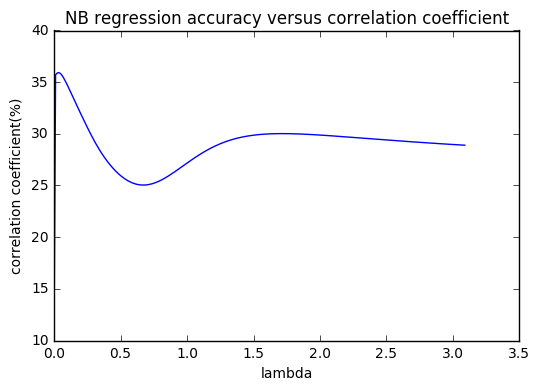

In [324]:
import matplotlib.pyplot as plt

_ = plt.plot(testRange, corrcoefs)
_ = plt.xlabel('lambda')
_ = plt.ylabel('correlation coefficient(%)')
_ = plt.title("NB regression accuracy versus correlation coefficient")
plt.show()
plt.close()

# 附录

## 参考资料

1.[stackoverflow : how-to-get-indices-of-n-maximum-values-in-a-numpy-array][1]

2.[stackoverflow : show-dataframe-as-table-in-ipython-notebook][2]

3.[Machine Learning-Normalization][3]

4.[为什么一些机器学习模型需要对数据进行归一化？][4]

5.[stackexchange : Standardizing some features in K-Means][5]

[1]:https://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array
[2]:https://stackoverflow.com/questions/26873127/show-dataframe-as-table-in-ipython-notebook
[3]:http://www.csuldw.com/2015/11/15/2015-11-15%20normalization/?utm_source=tuicool&utm_medium=referral
[4]:http://www.cnblogs.com/LBSer/p/4440590.html
[5]:https://stats.stackexchange.com/questions/223289/standardizing-some-features-in-k-means/223355#223355


## 相关函数测试

 **-------------------------------------------平台配置代码--------------------------------------------**

In [5]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

# from IPython.display import Image
# 其对应的三元顺序表为=Image("./images/1.jpg")
# 稀疏矩阵例子为=Image("./images/2.jpg")